### Initialize notebook

In [42]:
#!/home/akhanal1/Spring2018/pl-env/bin/python3.5
# Torch imports

import os
import sys
sys.path.append('/home/ak/Spring2018/ature')
os.chdir('/home/ak/Spring2018/ature')

import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import PIL.Image as IMG
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np

from commons.segmentation import AtureTest
from commons.IMAGE import SegmentedImage


from utils import img_utils as imgutil
from commons.IMAGE import Image
from neuralnet.hybridnet.hybridnet_trainer import SimpleNNTrainer
from neuralnet.hybridnet.hybridnet_dataloader import PatchesGenerator
import neuralnet.utils.measurements as mnt
import neuralnet.utils.data_utils as nndutils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
### Define folders. Create if needed.
sep = os.sep
Dirs = {}
Dirs['checkpoint']   = 'assests' +sep+ 'nnet_models'
Dirs['data']      = 'data'+sep+'DRIVE'+sep+'training'
Dirs['images']    = Dirs['data'] +sep+ 'images'
Dirs['mask']      = Dirs['data'] +sep+ 'mask'
Dirs['truth']     = Dirs['data'] +sep+ '1st_manual'

TestDirs = {}
TestDirs['data']      = 'data'+sep+'DRIVE'+sep+'test'
TestDirs['images']    = TestDirs['data'] +sep+ 'test_images'
TestDirs['mask']      = TestDirs['data'] +sep+ 'mask'
TestDirs['truth']     = TestDirs['data'] +sep+ '1st_manual'

ValidationDirs = {}
ValidationDirs['data']      = 'data'+sep+'DRIVE'+sep+'test'
ValidationDirs['images']    = ValidationDirs['data'] +sep+ 'validation_images'
ValidationDirs['mask']      = ValidationDirs['data'] +sep+ 'mask'
ValidationDirs['truth']     = ValidationDirs['data'] +sep+ '1st_manual'

for k, folder in Dirs.items():
    os.makedirs(folder, exist_ok=True)
for k, folder in TestDirs.items():
    os.makedirs(folder, exist_ok=True)
for k, folder in ValidationDirs.items():
    os.makedirs(folder, exist_ok=True)

def get_mask_file(file_name): 
    return file_name.split('_')[0] + '_training_mask.gif'

def get_ground_truth_file(file_name): 
    return file_name.split('_')[0] + '_manual1.gif'

def get_mask_file_test(file_name): 
    return file_name.split('_')[0] + '_test_mask.gif'

classes = { 'background': 0, 'vessel': 1,}
batch_size = 4
num_classes = len(classes)
epochs = 4
patch_w, patch_h = 11, 565
use_gpu = False

#### Images to train/validate per epoch ####
train_size = 500
validation_size = 100
checkpoint_file = 'PytorchCheckpointHybrid.nn.tar'

### Define the network

In [59]:
class Net(nn.Module):
    def __init__(self, input_width, input_height, channels):
        super(Net, self).__init__()
        
        self.channels = channels
        self.width = input_width
        self.height = input_height
        print(self.width, self.height)
    
        self.kern_size = 7
        self.kern_stride = 1
        self.kern_padding = 2
        self.conv1 = nn.Conv2d(self.channels, 24, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self.width = self._get_output_size(self.width, self.kern_size, self.kern_padding, self.kern_stride)
        self.height = self._get_output_size(self.height, self.kern_size, self.kern_padding, self.kern_stride)
        print(self.width, self.height)
        
        self.kern_size = 5
        self.kern_stride = 1     
        self.kern_padding = 1
        self.conv2 = nn.Conv2d(24, 52, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self.width = self._get_output_size(self.width, self.kern_size, self.kern_padding, self.kern_stride)
        self.height = self._get_output_size(self.height, self.kern_size, self.kern_padding, self.kern_stride)
        print(self.width, self.height)
        
        self.kern_size = 3
        self.kern_stride = 1      
        self.kern_padding = 3
        self.conv3 = nn.Conv2d(52, 96, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self.width = self._get_output_size(self.width, self.kern_size, self.kern_padding, self.kern_stride)
        self.height = self._get_output_size(self.height, self.kern_size, self.kern_padding, self.kern_stride)
        print(self.width, self.height)
        
        self.kern_size = 3
        self.kern_stride = 1      
        self.kern_padding = 1
        self.out = nn.Conv2d(96, num_classes, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self.width = self._get_output_size(self.width, self.kern_size, self.kern_padding, self.kern_stride)
        self.height = self._get_output_size(self.height, self.kern_size, self.kern_padding, self.kern_stride)
        print(self.width, self.height)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv3(x))
        x = F.tanh(self.out(x))
        return F.log_softmax(x, dim=1)
    
    def _get_output_size(self, w, f, p, s):       
        return ((w - f + 2 * p) / s) + 1


channels = 1
net = Net(patch_w, patch_h, channels)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

11 565
9.0 563.0
7.0 561.0
11.0 565.0
11.0 565.0


### Load train data

In [45]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

trainset = PatchesGenerator(Dirs=Dirs, train_image_size=(patch_w, patch_w), 
                                 transform=transform,
                                 fget_mask=get_mask_file, 
                                 fget_truth=get_ground_truth_file) 

# trainset.IDs = trainset.IDs[0:10]

train_size = trainset.__len__() if train_size is None else train_size
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          shuffle=False, num_workers=3, 
                                          sampler=WeightedRandomSampler(np.ones(len(trainset.IDs)), train_size))

### 1080 patches found.


### Load Validation Data

In [46]:
transform_val = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

validation_set = PatchesGenerator(Dirs=ValidationDirs, train_image_size=(patch_w, patch_w), 
                                       transform=transform_val,
                                       fget_mask=get_mask_file_test, 
                                       fget_truth=get_ground_truth_file) 

validation_size = validation_set.__len__() if validation_size is None else validation_size
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, 
                                            shuffle=False, num_workers=3,
                                            sampler=WeightedRandomSampler(np.ones(len(validation_set.IDs)), 
                                                                          validation_size, replacement=True))

### 162 patches found.


### Train and evaluate the Network

In [60]:
trainer = SimpleNNTrainer(model=net, checkpoint_dir=Dirs['checkpoint'], checkpoint_file=checkpoint_file)
# trainer.resume_from_checkpoint()
trainer.train(optimizer=optimizer, dataloader=trainloader, epochs=epochs, use_gpu=use_gpu, 
              validationloader=validationloader)
# trainer.resume_from_checkpoint()

Training...


/home/ak/anaconda/envs/ature_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Process Process-67:
Process Process-69:
Traceback (most recent call last):
Process Process-68:
Traceback (most recent call last):
  File "/home/ak/anaconda/envs/ature_env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ak/anaconda/envs/ature_env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ak/anaconda/envs/ature_env/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ak/anaconda/envs/ature_env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ak/anaconda/envs/ature_env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/ak/anaconda/envs/ature_env/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/ak/anaconda/envs/

  File "/home/ak/anaconda/envs/ature_env/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)


KeyboardInterrupt: 

  File "/home/ak/anaconda/envs/ature_env/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


### Test on a image

In [14]:
transform_test = transforms.Compose([
        imgutil.whiten_image2d,
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

testset = PatchesGenerator(Dirs=TestDirs, train_image_size=(patch_w, patch_h), 
                                transform=transform_test,
                                fget_mask=get_mask_file_test, 
                                fget_truth=get_ground_truth_file,
                                segment_mode=True) 

sampler=WeightedRandomSampler(np.ones(testset.__len__()), 100000, replacement=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, 
                                          shuffle=False, num_workers=3, sampler=None)

### 54 patches found.


In [13]:
IDs, IJs, scores, y_pred, y_true = trainer.evaluate(dataloader=testloader, use_gpu=use_gpu, force_checkpoint=False)
# mnt.plot_confusion_matrix(y_pred=y_pred, y_true=y_true, classes=classes)


Evaluating...
Batch[2181/2181] pre:1.000 rec:0.909 f1:0.952 acc:0.984
FINAL::: #Precision:0.642 #Recall:0.884 #F1:0.744 #Acc:0.924


### Convolve throughout the image to generate segmented image based on trained Network

In [14]:
sc = np.exp(scores.copy())
seg = np.zeros(testset.images[0].working_arr.shape)
for val in zip(IDs, IJs, sc):
    image_id, (i, j), (b_prob, v_prob) = val
    seg[i, j] = 255 * v_prob

In [29]:
# IMG.fromarray(255-seg.astype(np.uint8))#.save(checkpoint_file+testset.images[0].file_name+'.png')

In [ ]:
# params = {'sk_threshold': 150,
#           'alpha': 7.0,
#           'orig_contrib': 0.3,
#           'seg_threshold': 24}

# img_obj = SegmentedImage()

# img_obj.load_file(data_dir=TestDirs['images'], file_name=testset.images[0].file_name)
# img_obj.res['orig'] = img_obj.image_arr[:, :, 1]
# # img_obj.working_arr = 255 - seg.astype(np.uint8)

# img_obj.load_mask(mask_dir=TestDirs['mask'], fget_mask=get_mask_file_test, erode=True)
# img_obj.load_ground_truth(gt_dir=TestDirs['truth'], fget_ground_truth=get_ground_truth_file)

# img_obj.generate_skeleton(threshold=params['sk_threshold'])
# img_obj.generate_lattice_graph()

In [ ]:
# tester = AtureTest(out_dir='')
# tester.run(params=params, save_images=False, img_obj=img_obj)
# img_obj.res['scores']

In [16]:

for i in trainloader:
    x, y = i
    x = x.numpy()
    y = y.numpy()
    print(x.shape, y.shape)
    break

(4, 1, 11, 565) (4, 11, 565)


In [27]:
IMG.fromarray(np.array(y[1].squeeze()*255, dtype=np.uint8))

In [28]:
IMG.fromarray(np.array(x[1].squeeze()*255, dtype=np.uint8))

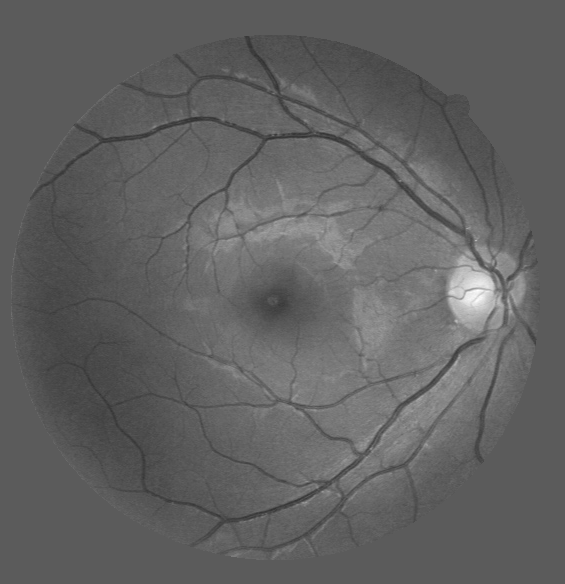

In [16]:
IMG.fromarray(trainset.images[0].working_arr)

In [39]:
trainset.IDs

[[0, 0, 11],
 [0, 11, 22],
 [0, 22, 33],
 [0, 33, 44],
 [0, 44, 55],
 [0, 55, 66],
 [0, 66, 77],
 [0, 77, 88],
 [0, 88, 99],
 [0, 99, 110],
 [0, 110, 121],
 [0, 121, 132],
 [0, 132, 143],
 [0, 143, 154],
 [0, 154, 165],
 [0, 165, 176],
 [0, 176, 187],
 [0, 187, 198],
 [0, 198, 209],
 [0, 209, 220],
 [0, 220, 231],
 [0, 231, 242],
 [0, 242, 253],
 [0, 253, 264],
 [0, 264, 275],
 [0, 275, 286],
 [0, 286, 297],
 [0, 297, 308],
 [0, 308, 319],
 [0, 319, 330],
 [0, 330, 341],
 [0, 341, 352],
 [0, 352, 363],
 [0, 363, 374],
 [0, 374, 385],
 [0, 385, 396],
 [0, 396, 407],
 [0, 407, 418],
 [0, 418, 429],
 [0, 429, 440],
 [0, 440, 451],
 [0, 451, 462],
 [0, 462, 473],
 [0, 473, 484],
 [0, 484, 495],
 [0, 495, 506],
 [0, 506, 517],
 [0, 517, 528],
 [0, 528, 539],
 [0, 539, 550],
 [0, 550, 561],
 [0, 561, 572],
 [0, 572, 583],
 [0, 573, 584],
 [1, 0, 11],
 [1, 11, 22],
 [1, 22, 33],
 [1, 33, 44],
 [1, 44, 55],
 [1, 55, 66],
 [1, 66, 77],
 [1, 77, 88],
 [1, 88, 99],
 [1, 99, 110],
 [1, 110, 121],


In [21]:
print('##HERE')
ID, row_from, row_to = trainset.IDs[440]
print('##HERE1')
img_tensor = trainset.images[ID].working_arr[row_from:row_to, :][..., None]
print('##HERE2')
y = trainset.images[ID].ground_truth[row_from:row_to, :]
print('##HERE3')
y = torch.LongTensor(y)
print('##HERE4')

##HERE
##HERE1
##HERE2
##HERE3
##HERE4


In [22]:
IMG.fromarray(img_tensor.squeeze())

In [12]:
img_tensor

array([[[95],
        [95],
        [95],
        ...,
        [95],
        [95],
        [95]],

       [[95],
        [95],
        [95],
        ...,
        [95],
        [95],
        [95]],

       [[95],
        [95],
        [95],
        ...,
        [95],
        [95],
        [95]],

       ...,

       [[95],
        [95],
        [95],
        ...,
        [95],
        [95],
        [95]],

       [[95],
        [95],
        [95],
        ...,
        [95],
        [95],
        [95]],

       [[95],
        [95],
        [95],
        ...,
        [95],
        [95],
        [95]]], dtype=uint8)

In [23]:
trainset.IDs[440]

[9, 66, 77]

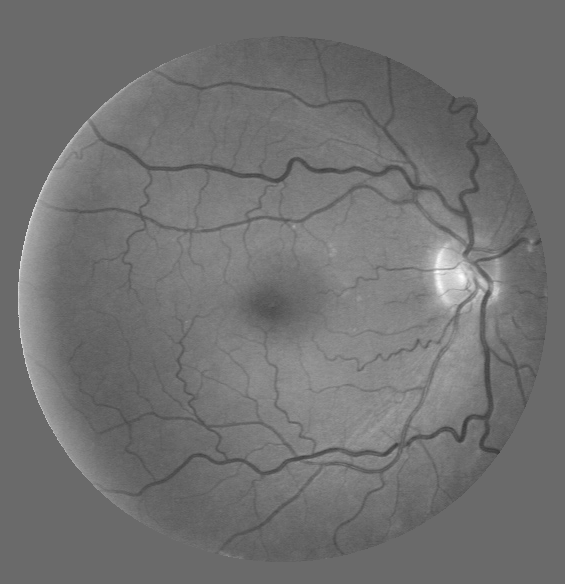

In [24]:
IMG.fromarray(trainset.images[9].working_arr
             )

In [9]:
trainloader.__len__()

125